In [1]:
# load libraries

import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

from action_prediction import constants as const
from action_prediction.data import DataSet
from action_prediction import visualize as vis
from action_prediction import inter_subject_congruency as isc

%load_ext autoreload
%autoreload 2

In [2]:
# initialize class 
data = DataSet(task='social_prediction')

# load behavior
df_behav = data.load_behav()

# load eyetracking
df_eye = data.load_eye(data_type='events')

# merge eyetracking with behav
df_merged = data.merge_behav_eye(dataframe_behav=df_behav, dataframe_eye=df_eye)


In [5]:
# get all tasks 
#looping and concatenating tasks, don't need
df_all = pd.DataFrame()
for task in const.tasks:
    data = DataSet(task=task)
    df_eye = data.load_eye(data_type='events')
    df_all = pd.concat([df_all, df_eye])   

KeyError: 'corr_resp'

In [3]:
# initialize plotting style
vis.plotting_style()

In [4]:
# summary plot

df = df_all.groupby(['task', 'type', 'subj'])['type'].count().reset_index(name="count")

sns.barplot(x='task', y='count', data=df.query('type=="saccade"'))
plt.ylabel('Saccade Count')

vis._save_fig(plt, 'saccade_count_all_tasks.png')

NameError: name 'df_all' is not defined

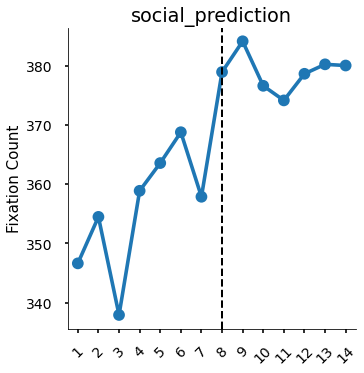

In [5]:
# plot fixation count
vis.plot_fixation_count(dataframe=df_merged, x='run_num', hue=None)  

In [ ]:
# plot fixation duration
vis.plot_fixation_duration(dataframe=df_all.query('task=="n_back"'), x='run_num', hue=None)

In [ ]:
sns.barplot(x='task', y='duration', data=df_all.query('type=="fixations"'))
plt.ylabel('Duration (ms)')

vis._save_fig(plt, 'fixation_duration_all_tasks.png')

In [ ]:
# visualize accuracy across runs
vis.plot_acc(dataframe=df_behav, x='run_num', hue=None)

In [ ]:
# visualize rt across runs
vis.plot_rt(dataframe=df_behav, x='run_num', hue=None)

In [ ]:
# plot diameter
# vis.plot_diameter(dataframe=df_merged)

## Visualization of Correlations
Another approach that visualizes correlations between subjects

reference source: https://medium.com/@sebastiannorena/finding-correlation-between-many-variables-multidimensional-dataset-with-python-5deb3f39ffb3

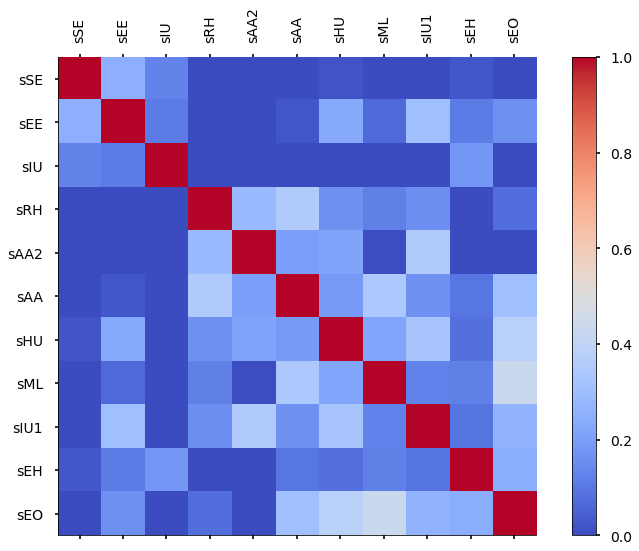

In [12]:
# get all subj fixations
fixations = isc.get_subj_fixations(dataframe=df_eye, data_type='events')

# grid subject data
gridded_data = isc.grid_all_subjects(fixations)

# visualize corr matrix
correlations = vis.visualize_corr(gridded_data)

# Inter-observer congruency

Idea: Build a saliency map from all observers except the ith observer. To calculate degree of similarity between ith observer and others, calculate hit rate. Iterate over all subjects and average scores to get the IOC.

Iterate over all fixation positions(x,y)
Convert fixation positions to gridded positions
For each grid position, map position to number of fixations in that grid position
Adaptive Binarization - yes or no whether some threshold number t or more fixations in that position

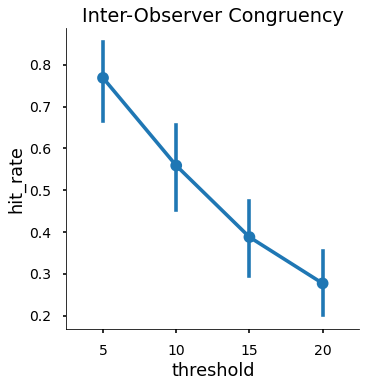

In [13]:
ioc_rates = isc.ioc(gridded_data=gridded_data, thresholds=[5, 10, 15, 20])

sns.factorplot(x='threshold', y='hit_rate', data=ioc_rates)
plt.title("Inter-Observer Congruency");

## Pairwise Comparison¶
To measure how much of a subject's fixations match with all other subjects'

Convert fixations to their locations in a grid
Since all the subjects have the same grid, the vectors being compared for each subject now all have the same length since each subject has one entry per grid position that contains the number of fixations at that position
Calculate correlation between each subject
Convert correlations to z-scores with Fisher Z-Transformation
Average z-scores
Convert to probabilities
Note on Fisher Z-Transformation:

The Fisher Z-Transformation is a way to transform the sampling distribution of Pearson’s r (i.e. the correlation coefficient) so that it becomes normally distributed. The “z” in Fisher Z stands for a z-score. The formula to transform r to a z-score is: z’ = .5[ln(1+r) – ln(1-r)]

<AxesSubplot:xlabel='observer', ylabel='avrg_zscore'>

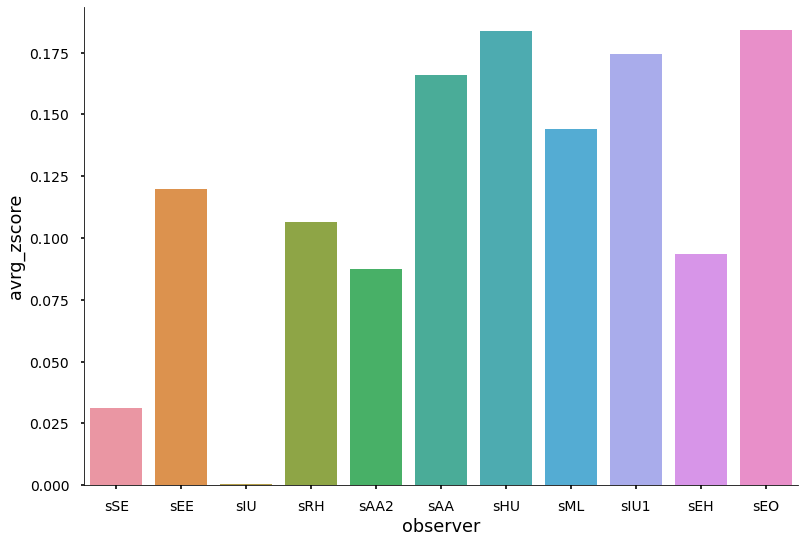

In [14]:
results = isc.pairwise(gridded_data)

sns.barplot(x='observer', y='avrg_zscore', data=results)
# sns.lineplot(x='observer', y='probability', data=results)

In [15]:
# plot saccade count
# vis.plot_saccade_count(dataframe=df_merged, x='run_num', hue=None)

In [ ]:
# plot amplitude
# vis.plot_amplitude(dataframe=df_merged, x='label', hue='condition_name')

In [ ]:
# plot dispersion
# vis.plot_dispersion(dataframe=df_merged, x='run_num', hue=None)

In [ ]:
# plot peak velocity
# vis.plot_peak_velocity(dataframe=df_merged, x='label', hue=None)

In [ ]:
# heatmap

# # one subj, one run
# for run in range(14):
#     tmp = df_eye[(df_eye['subj']=='sIU') & (df_eye['run_num']==run+1) & (df_eye['type']=="fixations")]
#     vis.plot_gaze_positions(dataframe=tmp)
#     plt.title(f'run{run+1}')

In [21]:
!pipenv install scikit-learn

Installing scikit-learn…
Adding scikit-learn to Pipfile's [packages]…
✔ Installation Succeeded 
Pipfile.lock (0ff8f5) out of date, updating to (d6f87f)…
Locking [dev-packages] dependencies…
✔ Success! 
Locking [packages] dependencies…
✔ Success! 
Updated Pipfile.lock (0ff8f5)!
Installing dependencies from Pipfile.lock (0ff8f5)…
  🐍   ▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉ 72/72 — 00:00:38mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import Ridge, LinearRegression
#!pip install plotly
import plotly.graph_objects as go

In [83]:
df_merged.subj.unique()

array(['sSE', 'sEE', 'sIU', 'sRH', 'sAA2', 'sAA', 'sHU', 'sML', 'sIU1',
       'sEH', 'sEO', 'sON', 'sEA', 'sAA1', 'sAE', 'sNH'], dtype=object)

In [113]:
df_merged.columns

Index(['peak_velocity', 'amplitude', 'dispersion', 'start_gx', 'start_gy',
       'end_gx', 'end_gy', 'surface', 'end_time', 'type', 'duration',
       'mean_gx', 'mean_gy', 'block_iter', 'exp_event', 'task', 'event_type',
       'run_num', 'subtract', 'onset_sec', 'subj', 'sess', 'start_time',
       'actors', 'agents', 'angle', 'balance_exp', 'condition_name', 'context',
       'corr_key', 'corr_resp', 'dataset', 'display_trial_feedback',
       'extracted', 'feedback_type', 'hand', 'initiator',
       'initiator_start_frames', 'initiator_start_frames_corr',
       'initiator_start_frames_sec', 'interact_start_frames',
       'interact_start_frames_corr', 'interact_start_frames_sec', 'iti_dur',
       'label', 'media', 'real_start_time', 'replace_stimuli', 'resp_made',
       'rt', 'run_iter', 'session_type', 'stim', 'timestamp_sec', 'trial_dur',
       'trial_type', 'video_end', 'video_name', 'video_name_corrected',
       'video_start', 'block_iter_corr'],
      dtype='object')

In [123]:
#amplitude and peak_velocity don't seem to have additional improved effect on RMSE

def get_model_features(model_type):
    if model_type=='eyetrack_1':
        quant_features = ['dispersion']
        qual_features = 'type'
    elif model_type=="eyetrack_2":
        quant_features = ['dispersion', 'duration']
        qual_features= 'type'
    elif model_type=="eyetrack_3":
        quant_features = ['duration']
        qual_features = 'type'
    elif model_type=='social_initiator':
        quant_features = ['rt']
        qual_features = 'initiator'
    elif model_type=="social_label":
        quant_features = ['rt']
        qual_features = 'label'
    elif model_type=="social_actor":
        quant_features = ['rt']
        qual_features = 'actors'
    elif model_type=="social_condition":
        quant_features = ['rt']
        qual_features = 'condition_name'
    else:
        print('please define model type')
    
    return quant_features, qual_features

In [127]:
model_types = ['eyetrack_1', 'eyetrack_2', 'eyetrack_3','social_initiator', 'social_label', 'social_actor', 'social_condition']

# loop over models
models = {}
for model_type in model_types:
    
    # get data for `subj`
    df_subj = df_merged[df_merged['subj']=='sAA1']
    
    # shuffle data before splitting
    shuffled_data = df_subj.sample(frac=1., random_state=42)

    # now split up the datasets into training and testing
    shuffled_data['corr_resp'] = shuffled_data['corr_resp'].astype(float)
    train, test = train_test_split(shuffled_data, test_size=0.1, random_state=83)

    # get model features
    quant_features, qual_features = get_model_features(model_type=model_type)
    
    # define model
    model = define_model(quant_features, qual_features)
    
    # fit model
    fitted_model = fit_model(model, train, train['corr_resp'])
    
    print(f'fitting {model_type} model')
    
    # add fitted model to dictionary
    models[model_type] = fitted_model

fig, training_rmse, validation_rmse = compare_models(models, train, test)
fig

ValueError: np.nan is an invalid document, expected byte or unicode string.

In [54]:
# model functions

def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

def cross_validate_rmse(model, train):
    model = clone(model)
    five_fold = KFold(n_splits=5)
    rmse_values = []
    for tr_ind, va_ind in five_fold.split(train):
        model.fit(train.iloc[tr_ind,:], train['corr_resp'].iloc[tr_ind])
        rmse_values.append(rmse(train['corr_resp'].iloc[va_ind], model.predict(train.iloc[va_ind,:])))
    return np.mean(rmse_values)

def compare_models(models, train, test):
    
    # Compute the training error for each model
    training_rmse = [rmse(train['corr_resp'], model.predict(train)) for model in models.values()]
    
    # Compute the cross validation error for each model
    validation_rmse = [cross_validate_rmse(model, train) for model in models.values()]
    
    # Compute the test error for each model (don't do this!)
    # WE SHOULD BE TESTING THE WINNING MODEL HERE (WHICHEVER MODEL YIELDED LOWEST TRAIN AND CV ERROR)
#     test_rmse = [rmse(test['corr_resp'], model.predict(test)) for model in models.values()]
    
    names = list(models.keys())
    fig = go.Figure([
        go.Bar(x = names, y = training_rmse, name="Training RMSE"),
        go.Bar(x = names, y = validation_rmse, name="CV RMSE")])
#         go.Bar(x = names, y = test_rmse, name="Test RMSE", opacity=.3)])
    return fig, training_rmse, validation_rmse

def define_model(quant_features, qual_features):
    model = Pipeline([
        ("SelectColumns", ColumnTransformer([
            ("keep", "passthrough", quant_features),
            ("text", CountVectorizer(), qual_features)
        ])),
        ("Imputation", SimpleImputer()),
        ("Ridge", Ridge())
    ])
    return model

def fit_model(model, train, y):
    return model.fit(train, y)